In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate


def load_monthly_data(csv_path):
    df = pd.read_csv(csv_path, sep=';', header=None)
    df['ds'] = pd.to_datetime({'year': df.iloc[:, 0], 'month': df.iloc[:, 1], 'day': 1})
    df['y'] = df.iloc[:, 3]
    df['y'] = df['y'].replace(-1, np.nan)
    df['y'] = df['y'].ffill().bfill()
    df['y'] = df['y'] + 1
    df = df.sort_values('ds')
    return df

def create_prophet_model(growth='linear', seasonality_mode='multiplicative', changepoint_prior_scale=0.001):
    model = Prophet(growth=growth, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=25,
                   seasonality_mode=seasonality_mode, yearly_seasonality=True, weekly_seasonality=False,
                   daily_seasonality=False, n_changepoints=100, interval_width=0.95)
    model.add_seasonality(name='solar_cycle', period=365.25 * 11, fourier_order=10, prior_scale=30)
    return model

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

def plot_forecast(model, forecast, df_train, period, title):
    plt.figure(figsize=(15, 8))
    recent_data = df_train[df_train['ds'] >= df_train['ds'].max() - pd.DateOffset(years=2)]
    plt.plot(recent_data['ds'], recent_data['y'], 'b.', alpha=0.5, label='Historical', markersize=2)
    forecast_mask = forecast['ds'] >= df_train['ds'].max()
    plt.plot(forecast.loc[forecast_mask, 'ds'], forecast.loc[forecast_mask, 'yhat'],
            'r-', linewidth=2, label='Forecast')
    plt.fill_between(forecast.loc[forecast_mask, 'ds'],
                    forecast.loc[forecast_mask, 'yhat_lower'],
                    forecast.loc[forecast_mask, 'yhat_upper'],
                    color='r', alpha=0.1)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sunspot Number')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_forecast(df, periods, time_unit='D'):
    cutoff_date = df['ds'].max() - pd.DateOffset(years=22)
    df_train = df[df['ds'] >= cutoff_date].copy()
    
    growth_options = ['linear', 'logistic', 'flat']
    
    for growth in growth_options:
        if growth == 'logistic':
            df_train['cap'] = df_train['y'].max() * 1.5
            
        model = create_prophet_model(growth=growth)
        model.fit(df_train)
        
        for period in periods:
            future = model.make_future_dataframe(periods=period, freq=time_unit)
            if growth == 'logistic':
                future['cap'] = df_train['y'].max() * 1.5
                
            forecast = model.predict(future)
            metrics = evaluate_model(df_train['y'], forecast['yhat'][:len(df_train)])
            
            for metric, value in metrics.items():
                print(f"{metric}: {value:.3f}")
                
            plot_forecast(model, forecast, df_train, period, 
                        f'Sunspots Forecast - Next {period} {time_unit} ({growth} growth)')
            
            future_predictions = forecast[forecast['ds'] > df_train['ds'].max()]
            pred_table = future_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()
            print(tabulate(pred_table, headers='keys', tablefmt='pipe', floatfmt='.2f'))
            
        model.plot_components(forecast)
        plt.show()

18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
18:52:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:26 - cmdstanpy - INFO - Chain [1] start processing


Monthly Forecast


18:52:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


MAE: 14.512
RMSE: 20.343
R²: 0.866


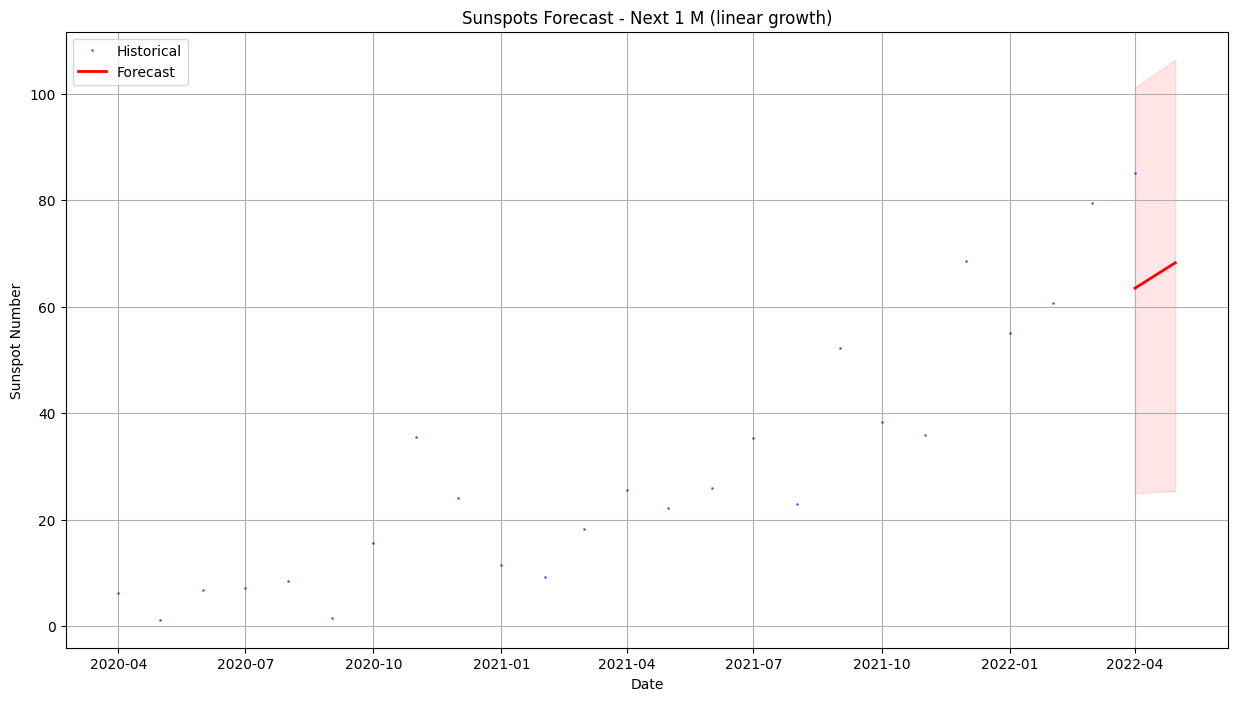

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 |  68.24 |        25.37 |       106.37 |
MAE: 14.512
RMSE: 20.343
R²: 0.866


/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


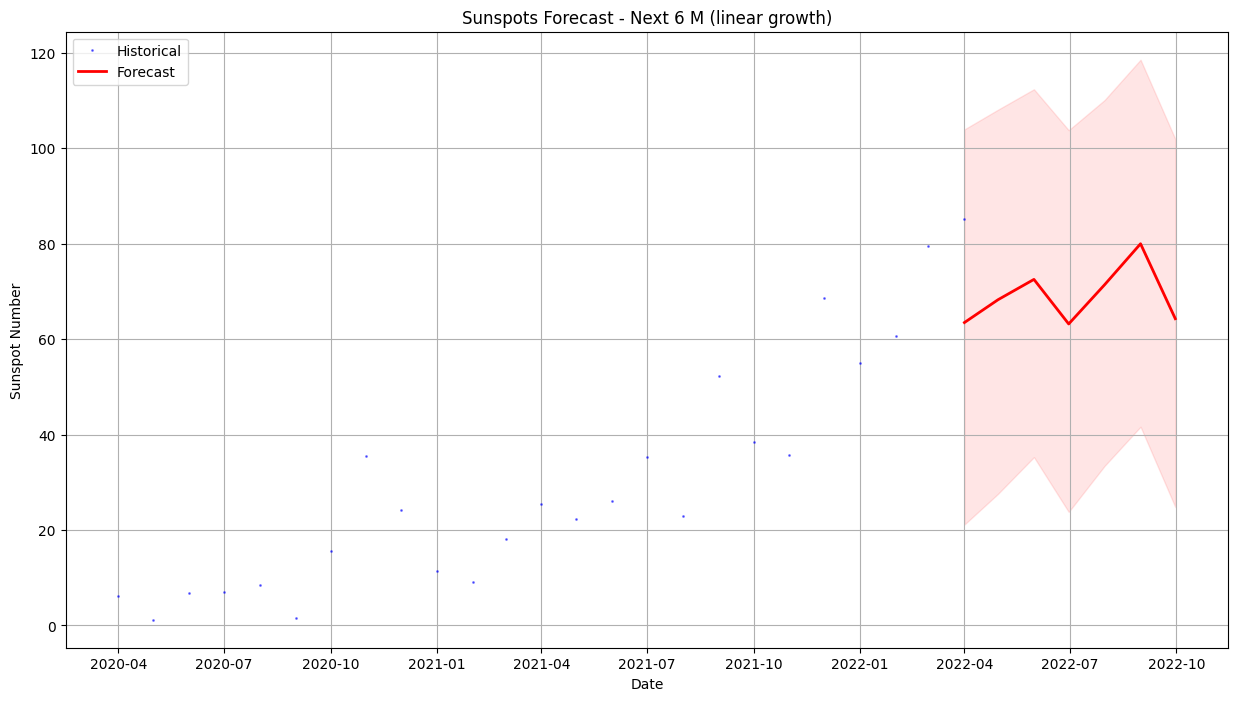

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 |  68.24 |        27.57 |       108.06 |
| 266 | 2022-05-31 00:00:00 |  72.50 |        35.27 |       112.34 |
| 267 | 2022-06-30 00:00:00 |  63.17 |        23.79 |       103.76 |
| 268 | 2022-07-31 00:00:00 |  71.39 |        33.43 |       110.09 |
| 269 | 2022-08-31 00:00:00 |  79.97 |        41.63 |       118.52 |


/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


MAE: 14.512
RMSE: 20.343
R²: 0.866


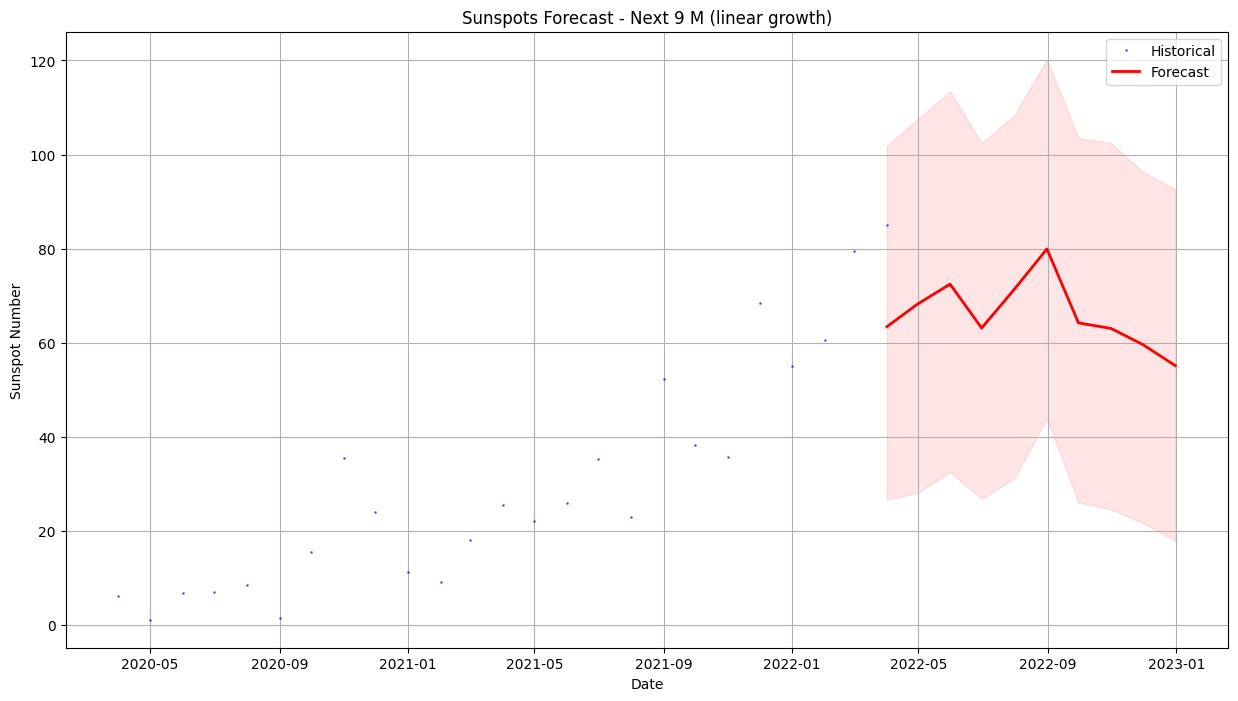

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 |  68.24 |        28.13 |       107.49 |
| 266 | 2022-05-31 00:00:00 |  72.50 |        32.59 |       113.44 |
| 267 | 2022-06-30 00:00:00 |  63.17 |        26.89 |       102.44 |
| 268 | 2022-07-31 00:00:00 |  71.39 |        31.25 |       108.34 |
| 269 | 2022-08-31 00:00:00 |  79.97 |        43.92 |       120.16 |


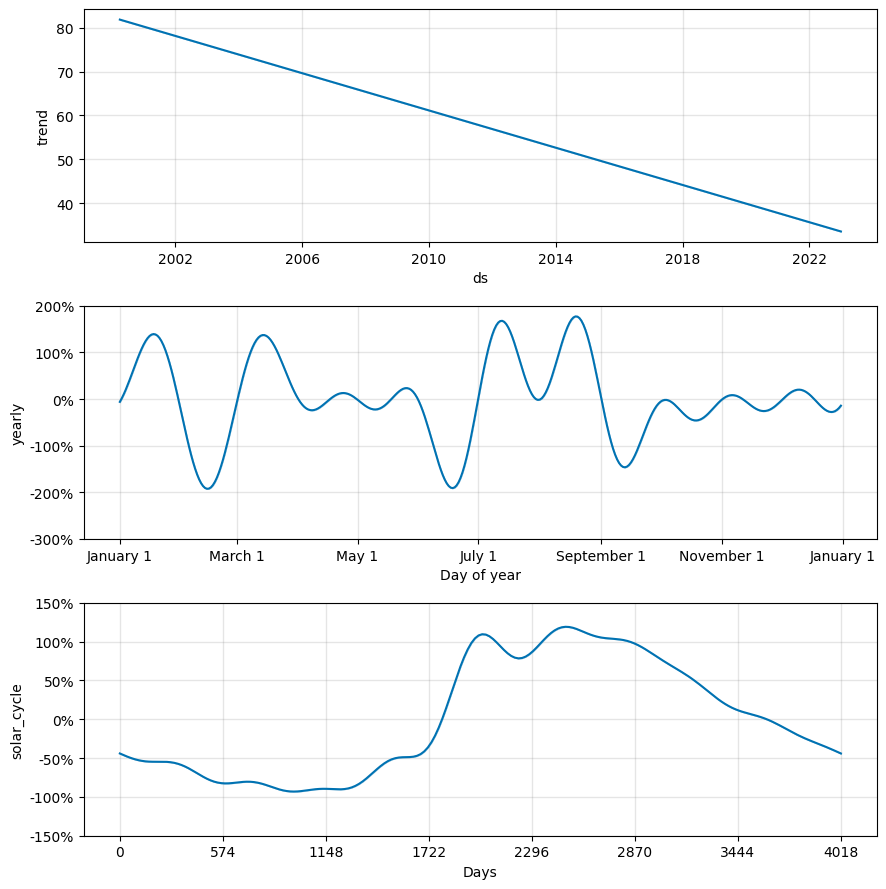

18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
18:52:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


MAE: 14.177
RMSE: 19.769
R²: 0.874


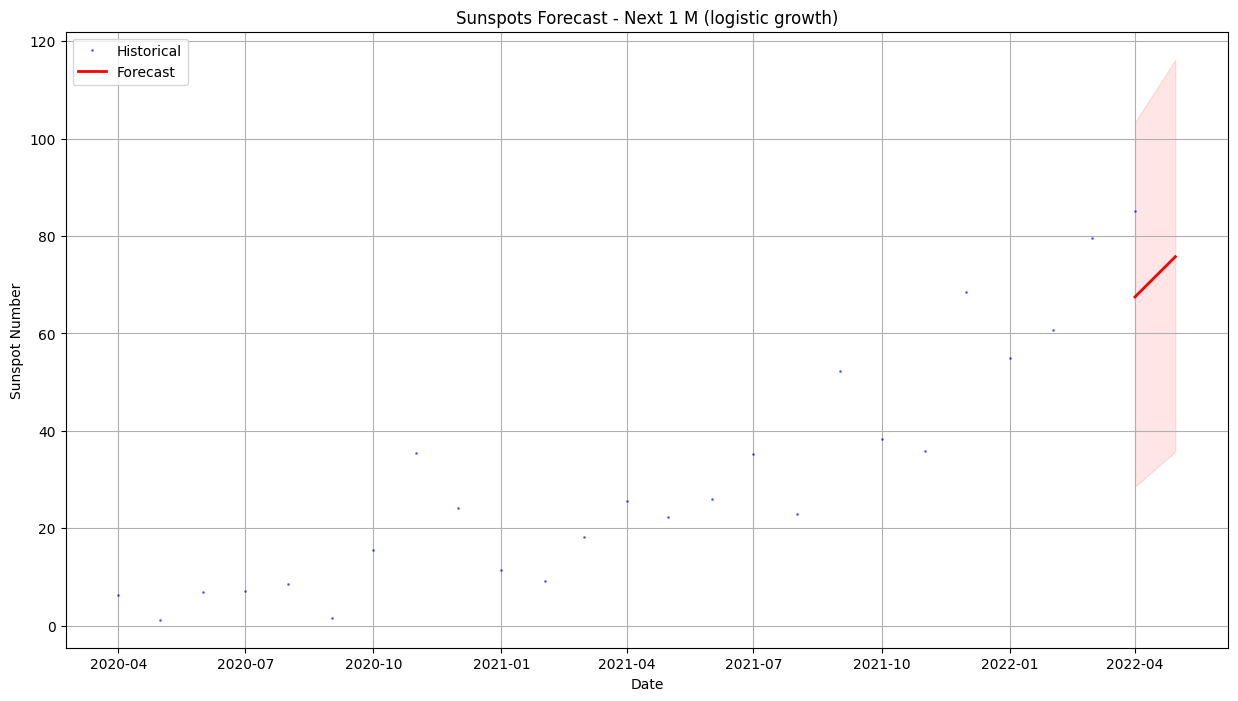

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 |  75.76 |        35.74 |       116.21 |
MAE: 14.177
RMSE: 19.769
R²: 0.874


/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


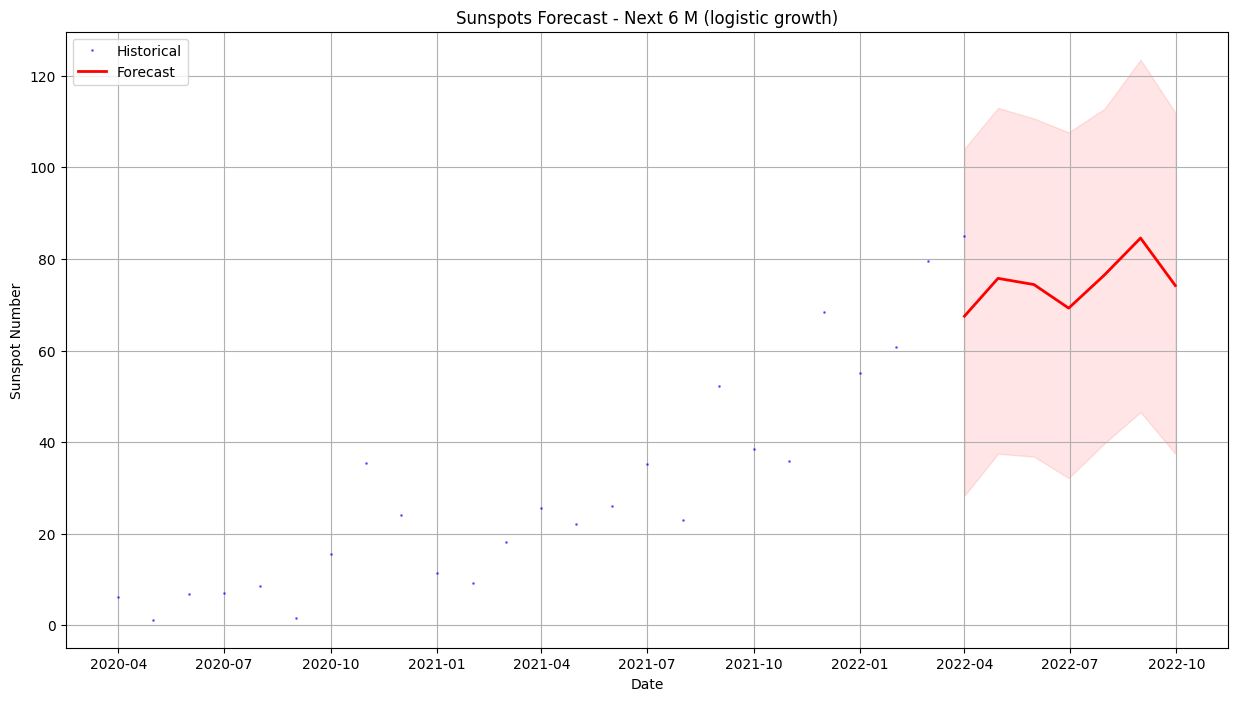

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 |  75.76 |        37.45 |       112.97 |
| 266 | 2022-05-31 00:00:00 |  74.40 |        36.82 |       110.68 |
| 267 | 2022-06-30 00:00:00 |  69.25 |        32.14 |       107.64 |
| 268 | 2022-07-31 00:00:00 |  76.53 |        39.74 |       112.82 |
| 269 | 2022-08-31 00:00:00 |  84.56 |        46.55 |       123.51 |
MAE: 14.177
RMSE: 19.769
R²: 0.874


/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


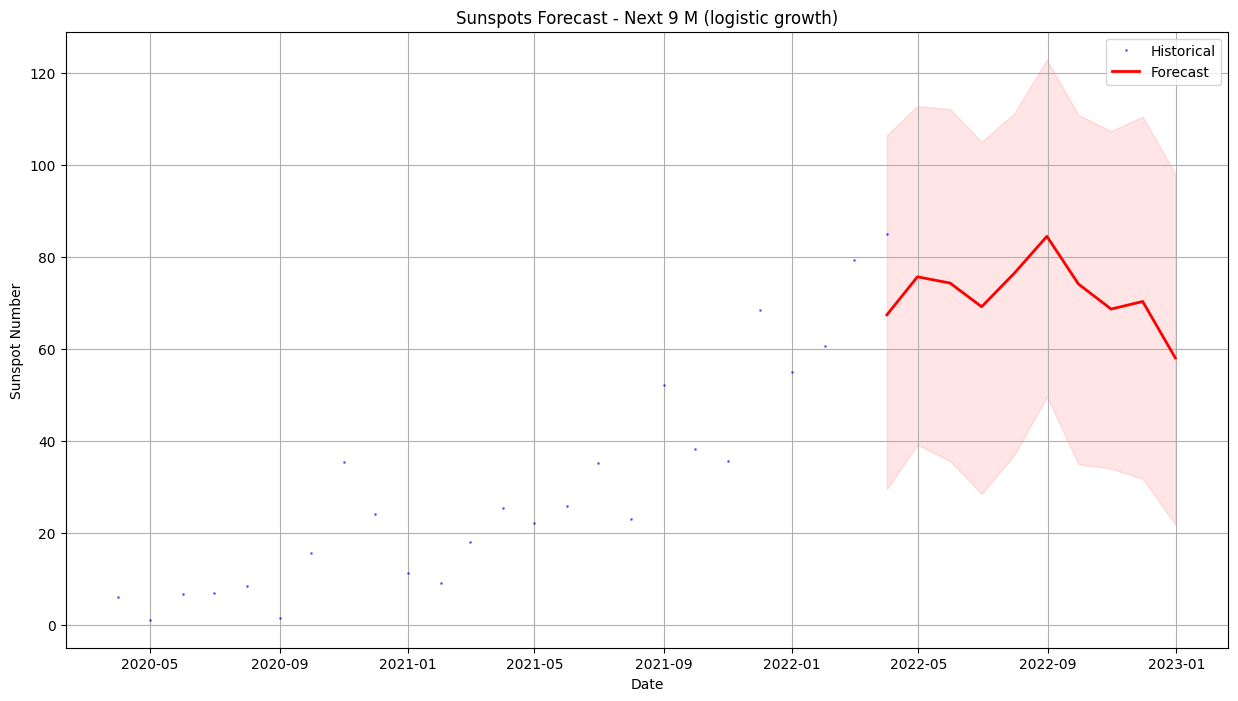

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 |  75.76 |        39.26 |       112.88 |
| 266 | 2022-05-31 00:00:00 |  74.40 |        35.69 |       112.22 |
| 267 | 2022-06-30 00:00:00 |  69.25 |        28.56 |       105.11 |
| 268 | 2022-07-31 00:00:00 |  76.53 |        36.95 |       111.30 |
| 269 | 2022-08-31 00:00:00 |  84.56 |        49.70 |       122.96 |


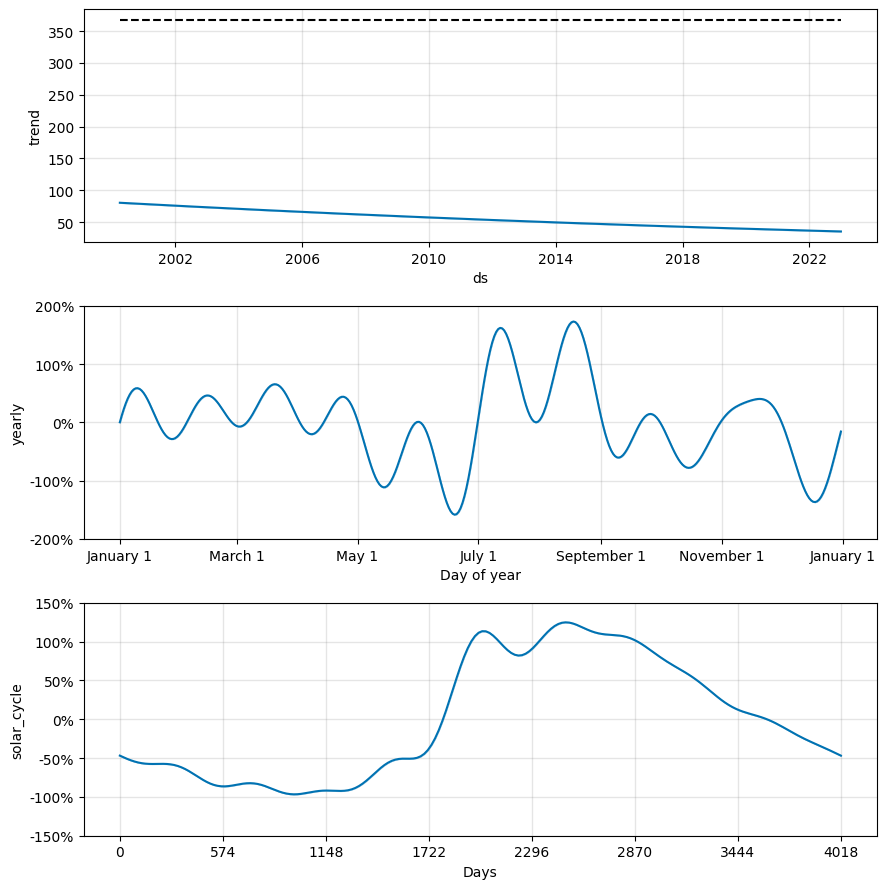

18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


MAE: 16.222
RMSE: 25.264
R²: 0.794


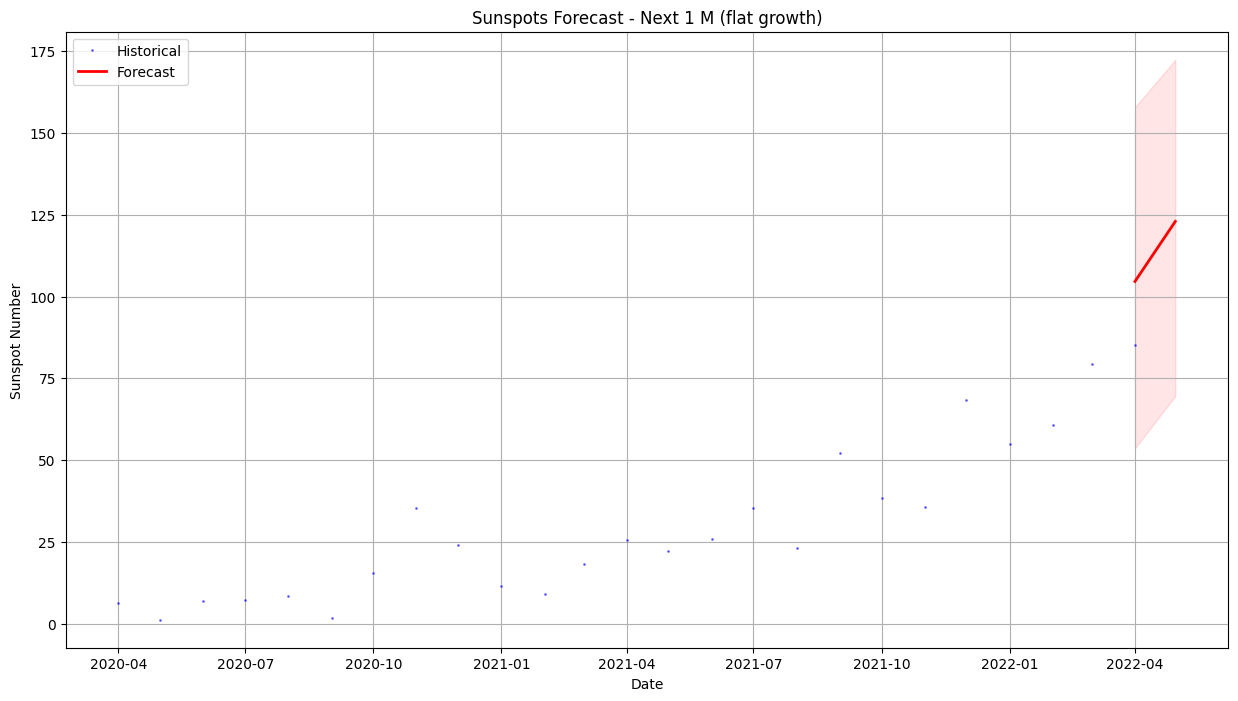

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 | 122.99 |        69.58 |       172.44 |
MAE: 16.222
RMSE: 25.264
R²: 0.794


/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


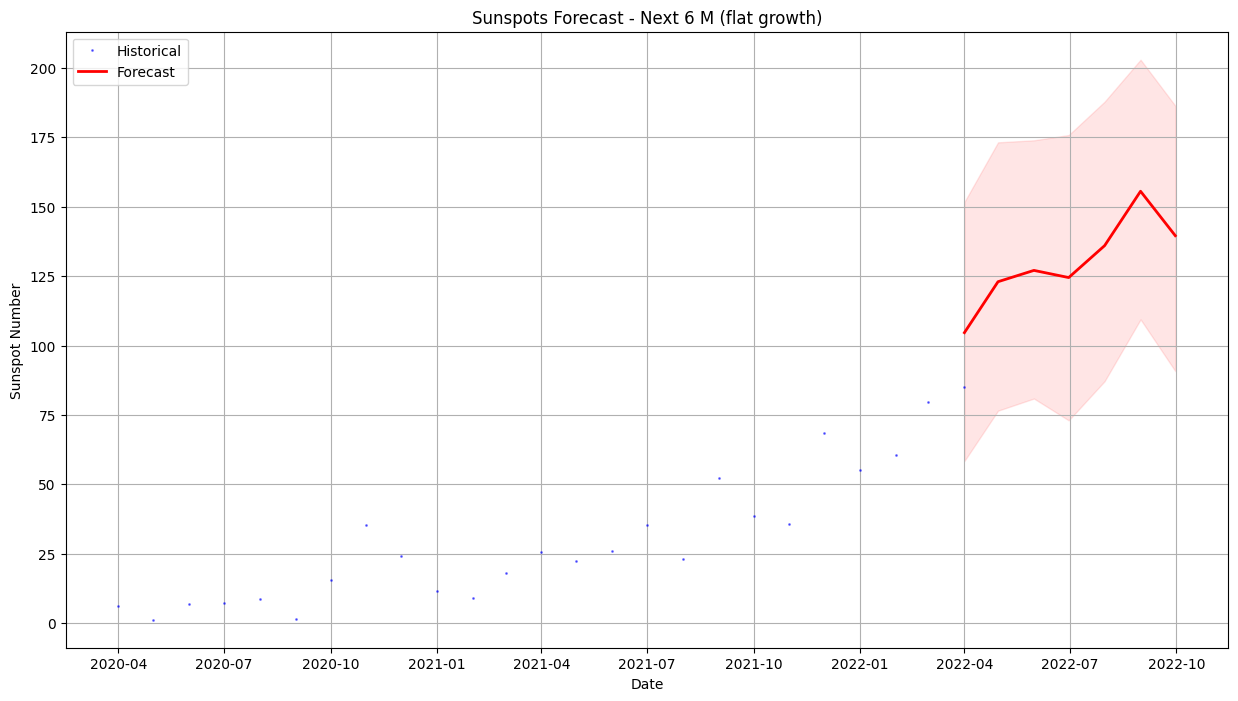

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 | 122.99 |        76.52 |       173.21 |
| 266 | 2022-05-31 00:00:00 | 127.07 |        80.90 |       173.95 |
| 267 | 2022-06-30 00:00:00 | 124.49 |        73.03 |       175.84 |
| 268 | 2022-07-31 00:00:00 | 135.99 |        87.15 |       187.88 |
| 269 | 2022-08-31 00:00:00 | 155.59 |       109.42 |       202.98 |
MAE: 16.222
RMSE: 25.264
R²: 0.794


/Users/vedavrathpathi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


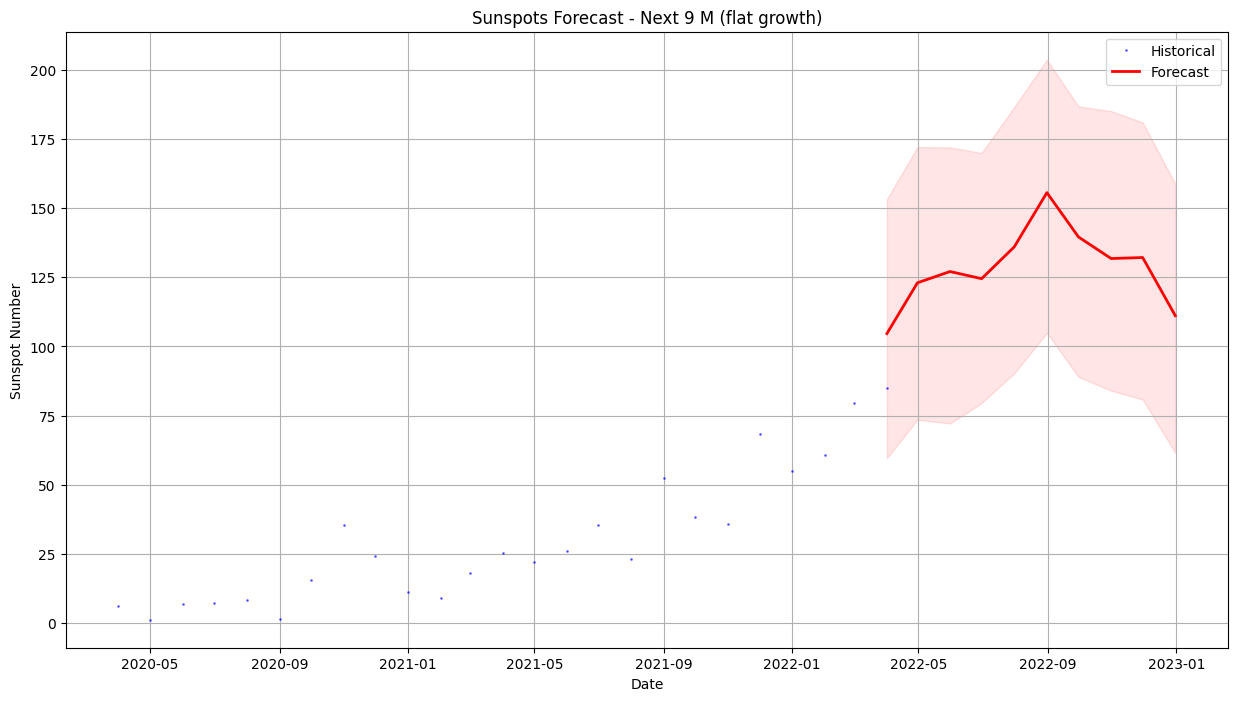

|     | ds                  |   yhat |   yhat_lower |   yhat_upper |
|----:|:--------------------|-------:|-------------:|-------------:|
| 265 | 2022-04-30 00:00:00 | 122.99 |        73.53 |       172.10 |
| 266 | 2022-05-31 00:00:00 | 127.07 |        72.14 |       171.94 |
| 267 | 2022-06-30 00:00:00 | 124.49 |        79.51 |       169.96 |
| 268 | 2022-07-31 00:00:00 | 135.99 |        90.25 |       186.58 |
| 269 | 2022-08-31 00:00:00 | 155.59 |       104.88 |       203.64 |


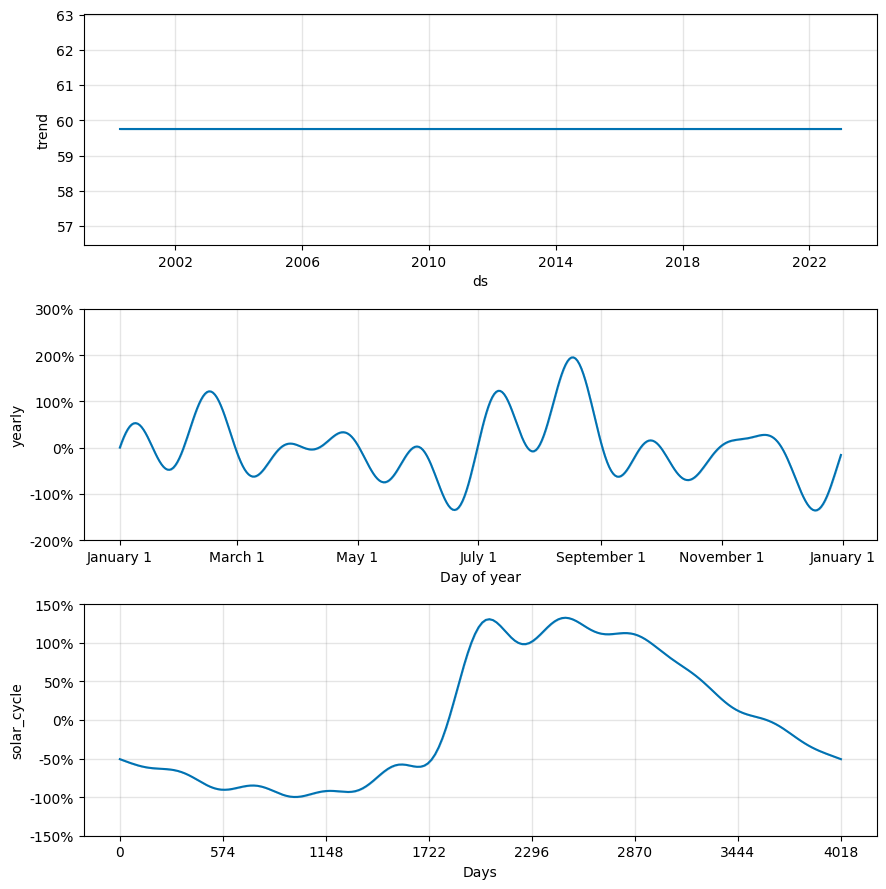

In [8]:
df = load_monthly_data("SN_m_tot_V2.0.csv")

print("Monthly Forecast")
run_forecast(df, [1, 6, 9], 'M')